In [1]:
%matplotlib notebook

In [2]:
from ipywidgets import FloatProgress

In [36]:
import tensorflow as tf
import pandas as pd
import librosa
import librosa.display
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import hickle as hkl
import multiprocessing
import os
import os.path

In [4]:
tf.enable_eager_execution()

In [5]:
data = pd.read_csv('./data/cv_corpus_v1/cv-valid-train.csv')

In [66]:
test_data = pd.read_csv('./data/cv_corpus_v1/cv-valid-test.csv')

In [61]:
test_data.shape

(3995, 8)

In [67]:
eval_data = test_data[1995:]
test_data = test_data[:1995]

In [73]:
test_data.shape

(657, 8)

In [74]:
eval_data.shape

(663, 8)

In [11]:
data.head(n=6)

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN


In [12]:
data = data[data.age.notnull() & data.gender.notnull() & data.accent.notnull()]
test_data = test_data[test_data.age.notnull() & test_data.gender.notnull() & test_data.accent.notnull()]
eval_data = eval_data[eval_data.age.notnull() & eval_data.gender.notnull() & eval_data.accent.notnull()]

In [13]:
data.gender = data.gender.astype('category')
data.age = data.age.astype('category')
data.accent = data.accent.astype('category')

test_data.gender = test_data.gender.astype('category')
test_data.age = test_data.age.astype('category')
test_data.accent = test_data.accent.astype('category')

eval_data.gender = eval_data.gender.astype('category')
eval_data.age = eval_data.age.astype('category')
eval_data.accent = eval_data.accent.astype('category')

In [14]:
data.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN
8,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN
13,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN
14,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN
19,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN


In [15]:
data.shape

(63163, 8)

In [16]:
data.gender.dtype

CategoricalDtype(categories=[u'female', u'male', u'other'], ordered=False)

<IPython.core.display.Javascript object>


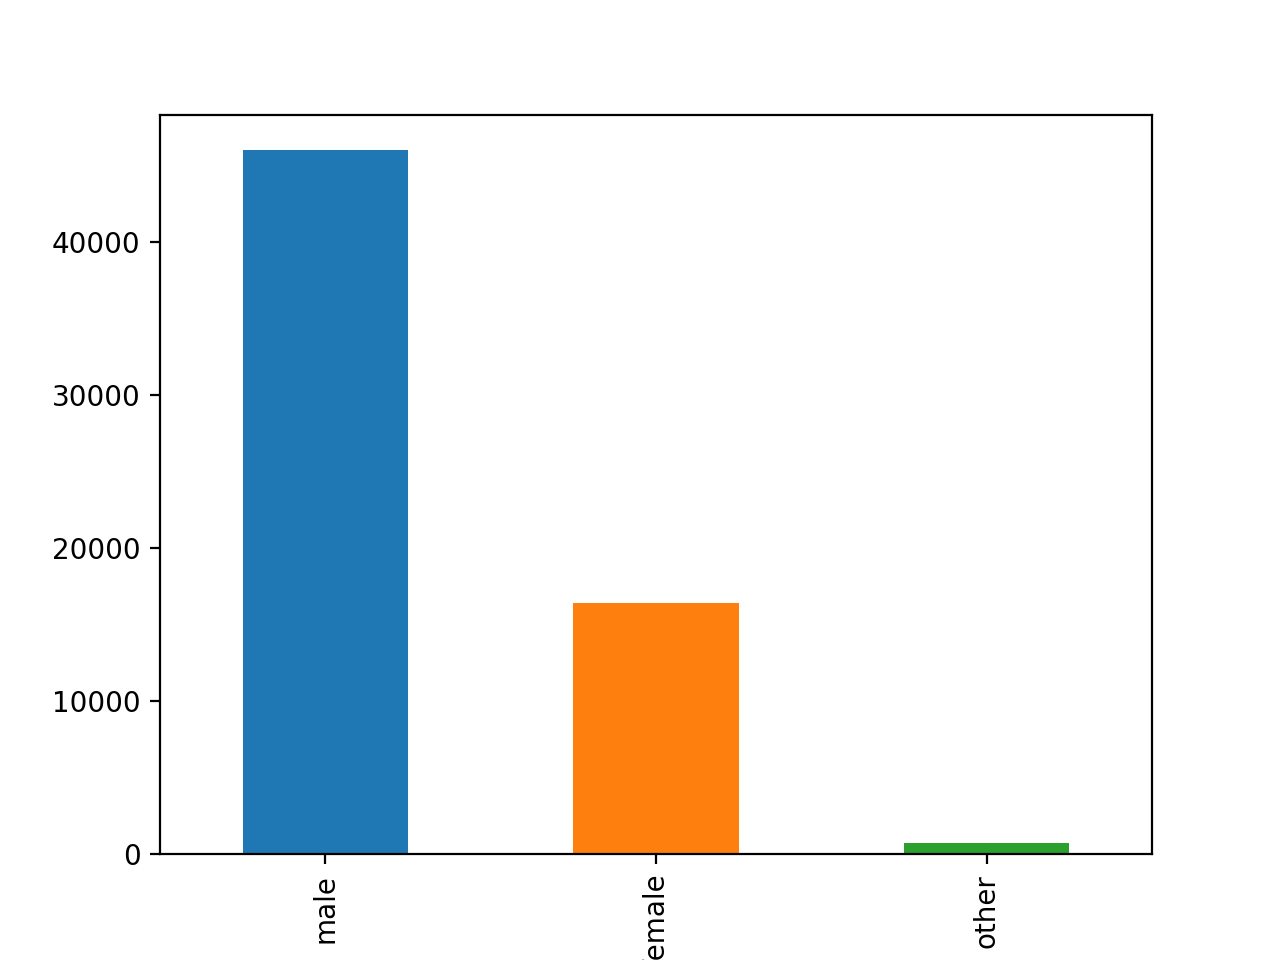

In [17]:
data.gender.value_counts().plot(kind='bar')

In [18]:
data.age.dtype

CategoricalDtype(categories=[u'eighties', u'fifties', u'fourties', u'seventies',
                  u'sixties', u'teens', u'thirties', u'twenties'],
                 ordered=False)

<IPython.core.display.Javascript object>


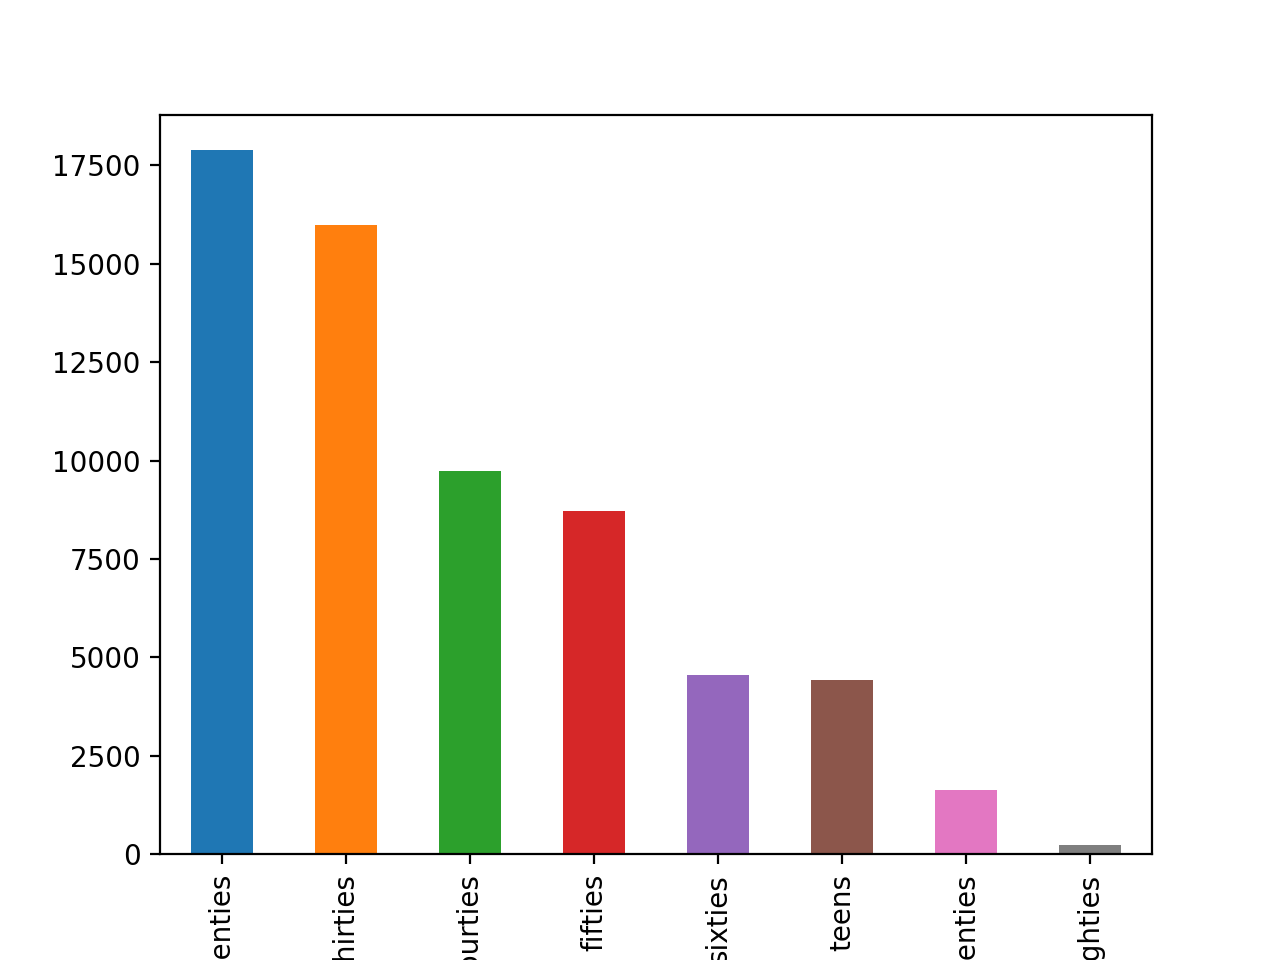

In [19]:
data.age.value_counts().plot(kind='bar')

In [20]:
data.accent.dtype

CategoricalDtype(categories=[u'african', u'australia', u'bermuda', u'canada', u'england',
                  u'hongkong', u'indian', u'ireland', u'malaysia',
                  u'newzealand', u'philippines', u'scotland', u'singapore',
                  u'southatlandtic', u'us', u'wales'],
                 ordered=False)

<IPython.core.display.Javascript object>


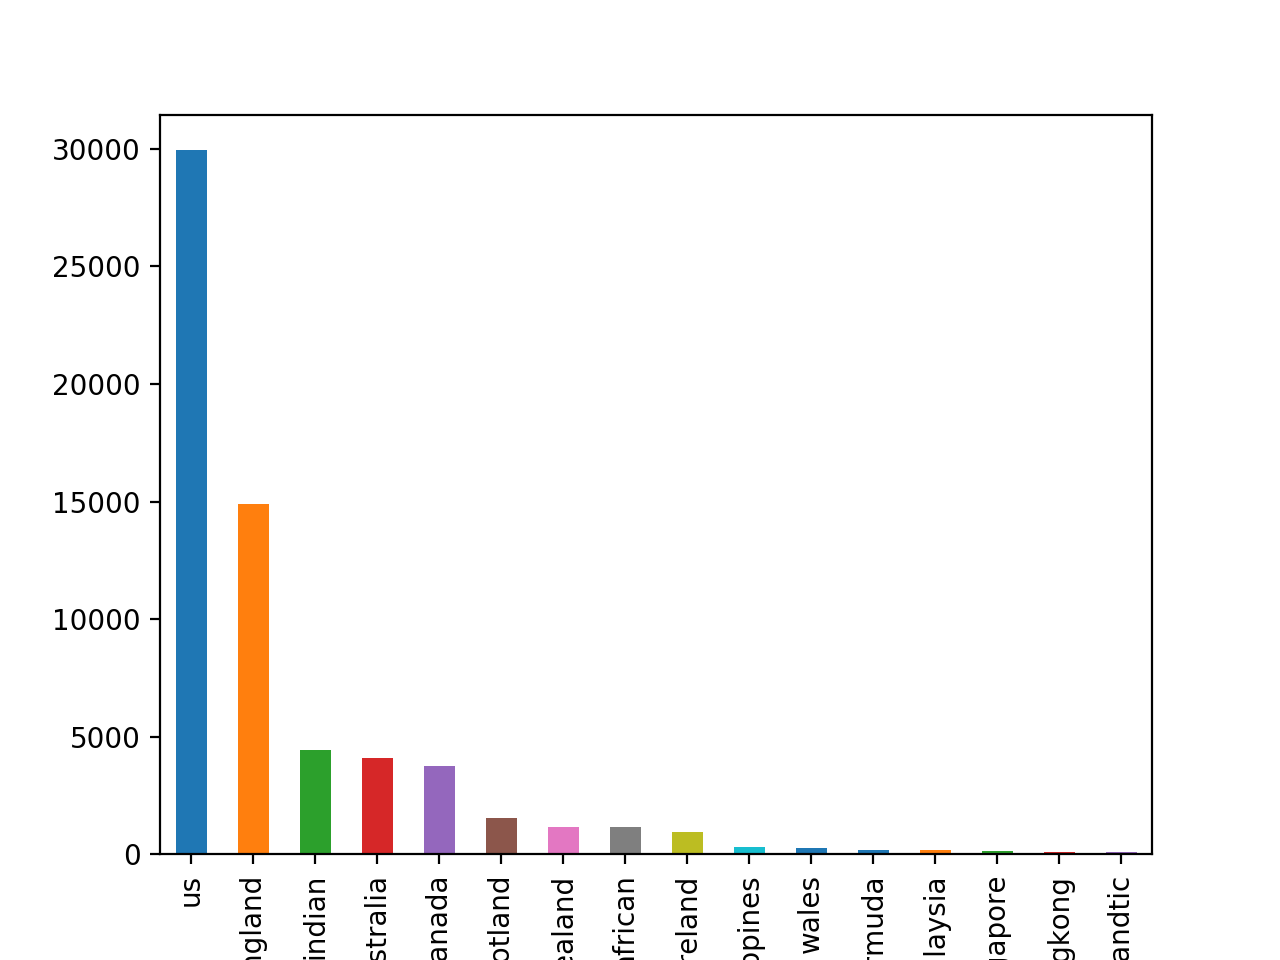

In [21]:
data.accent.value_counts().plot(kind='bar')

<IPython.core.display.Javascript object>


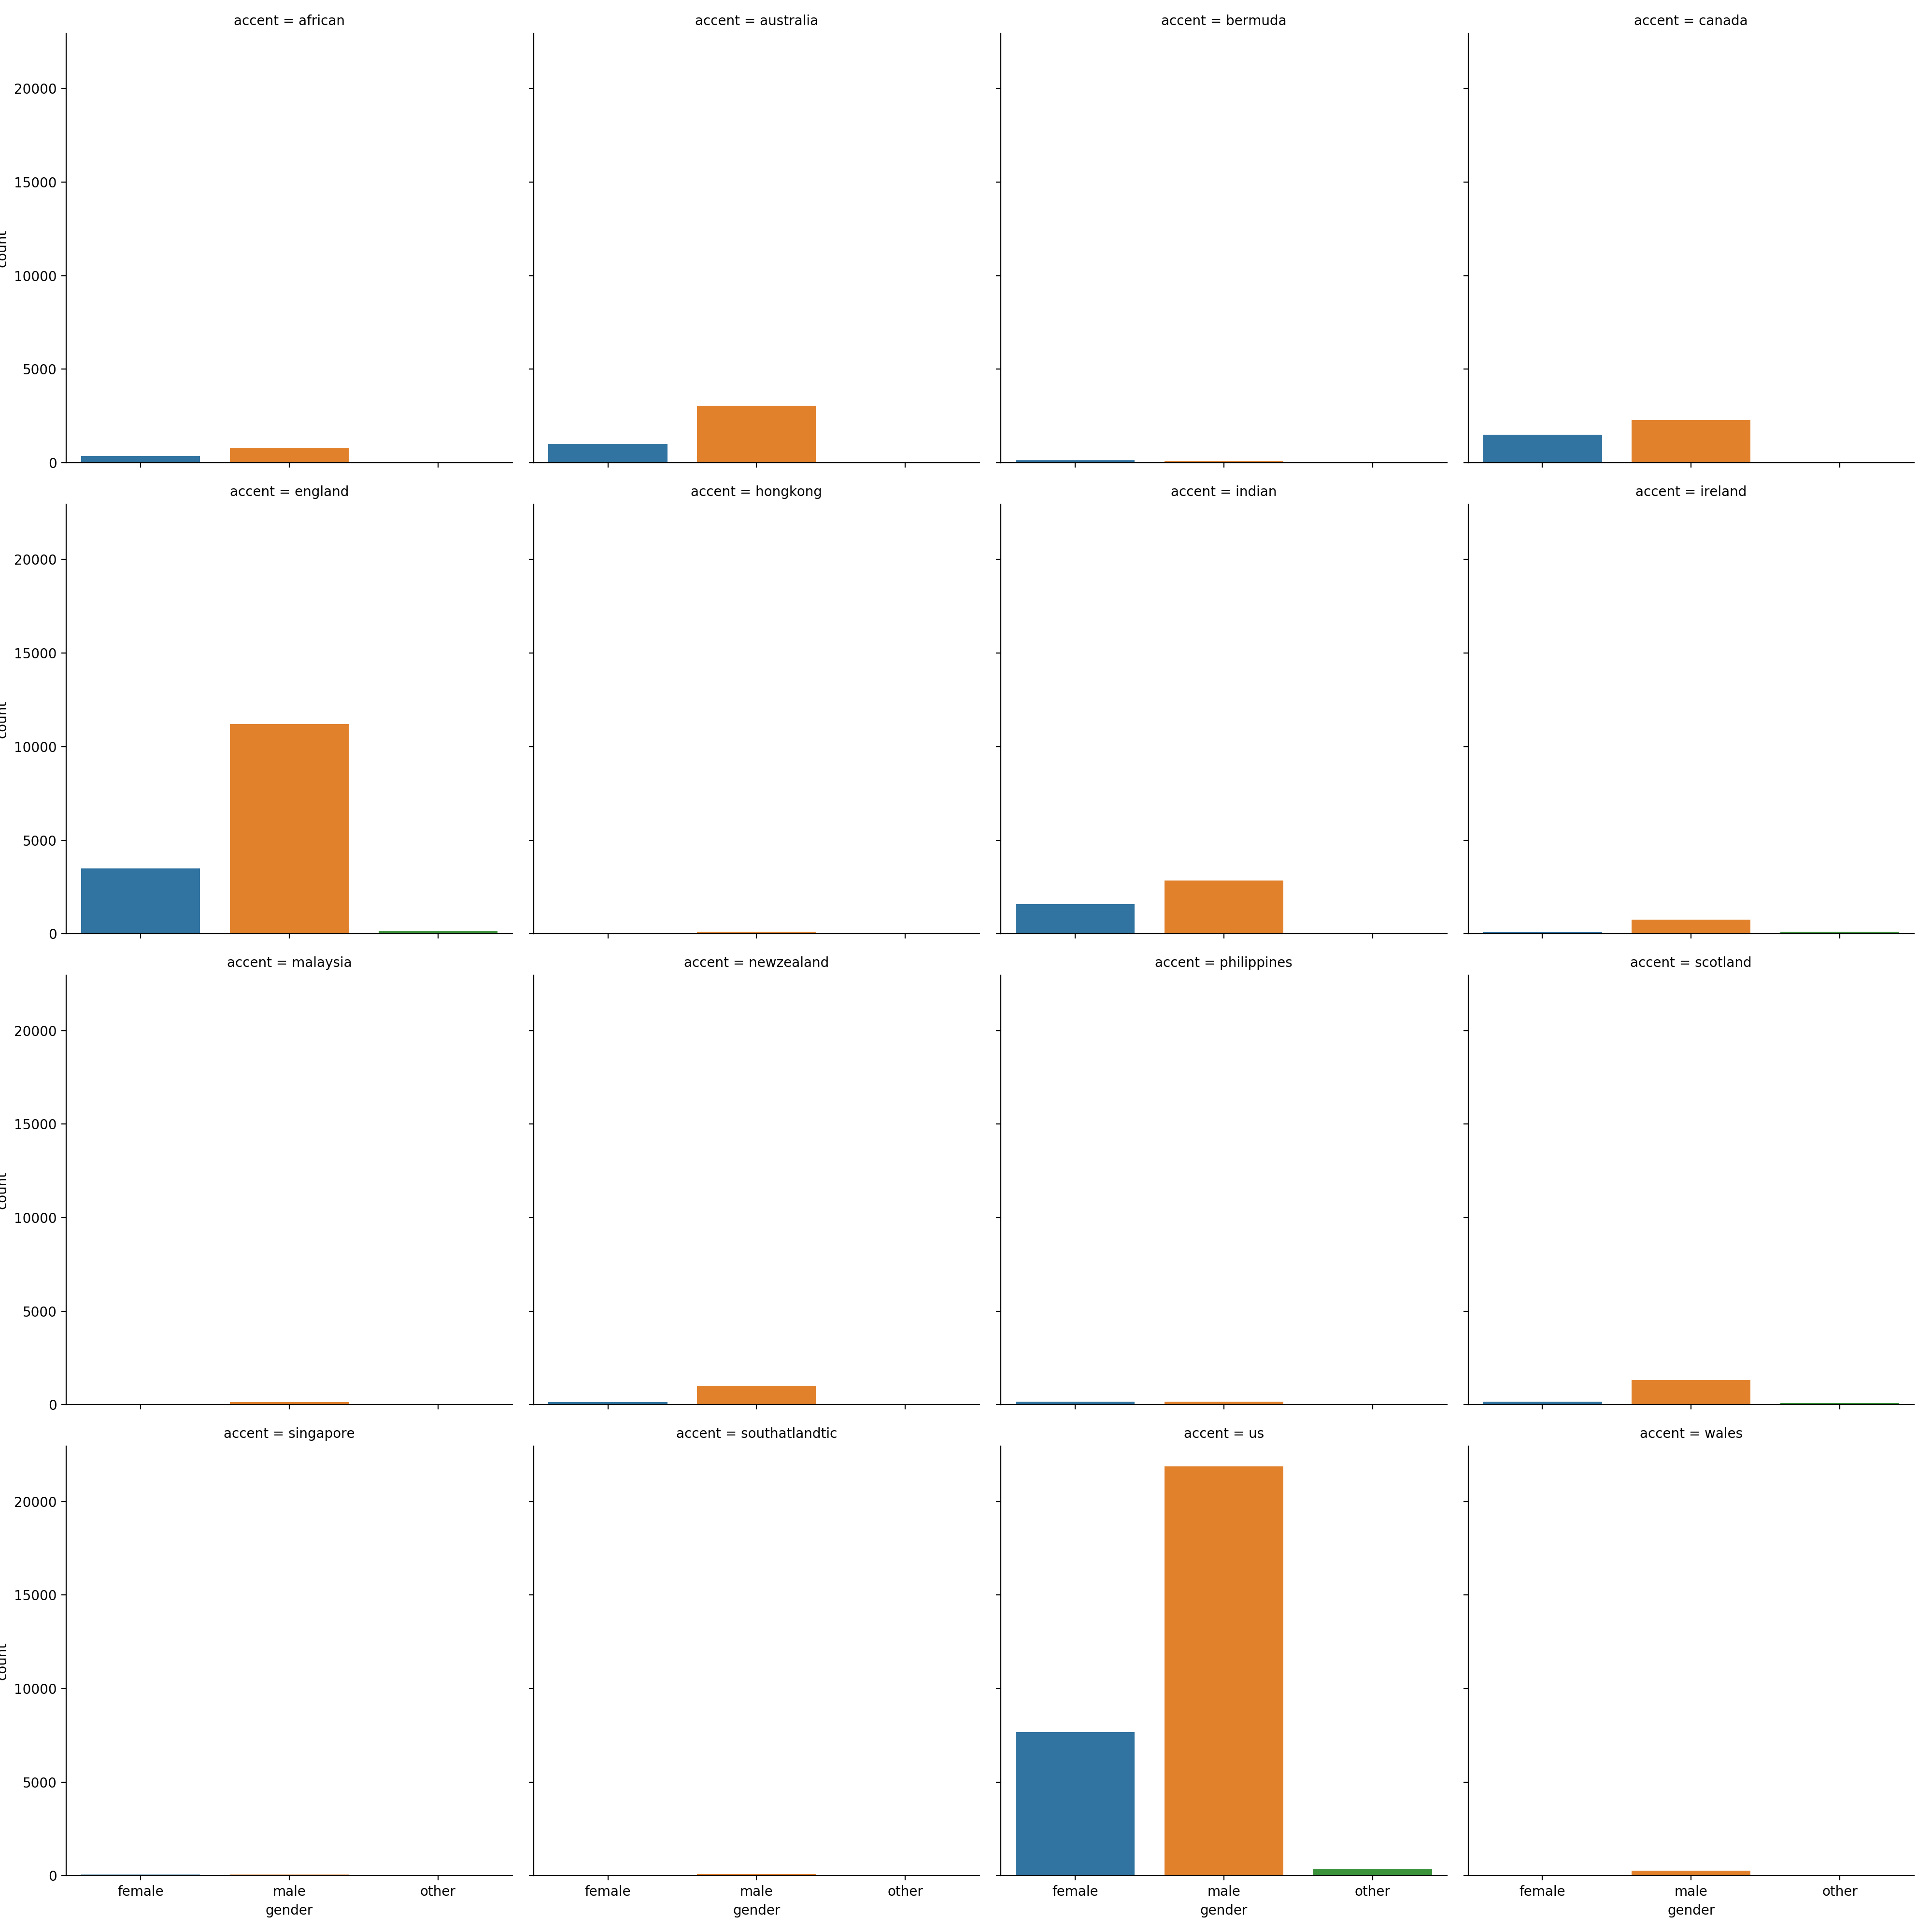

In [22]:
sns.catplot(data=data, x='gender', kind='count', col='accent', col_wrap=4)

<IPython.core.display.Javascript object>


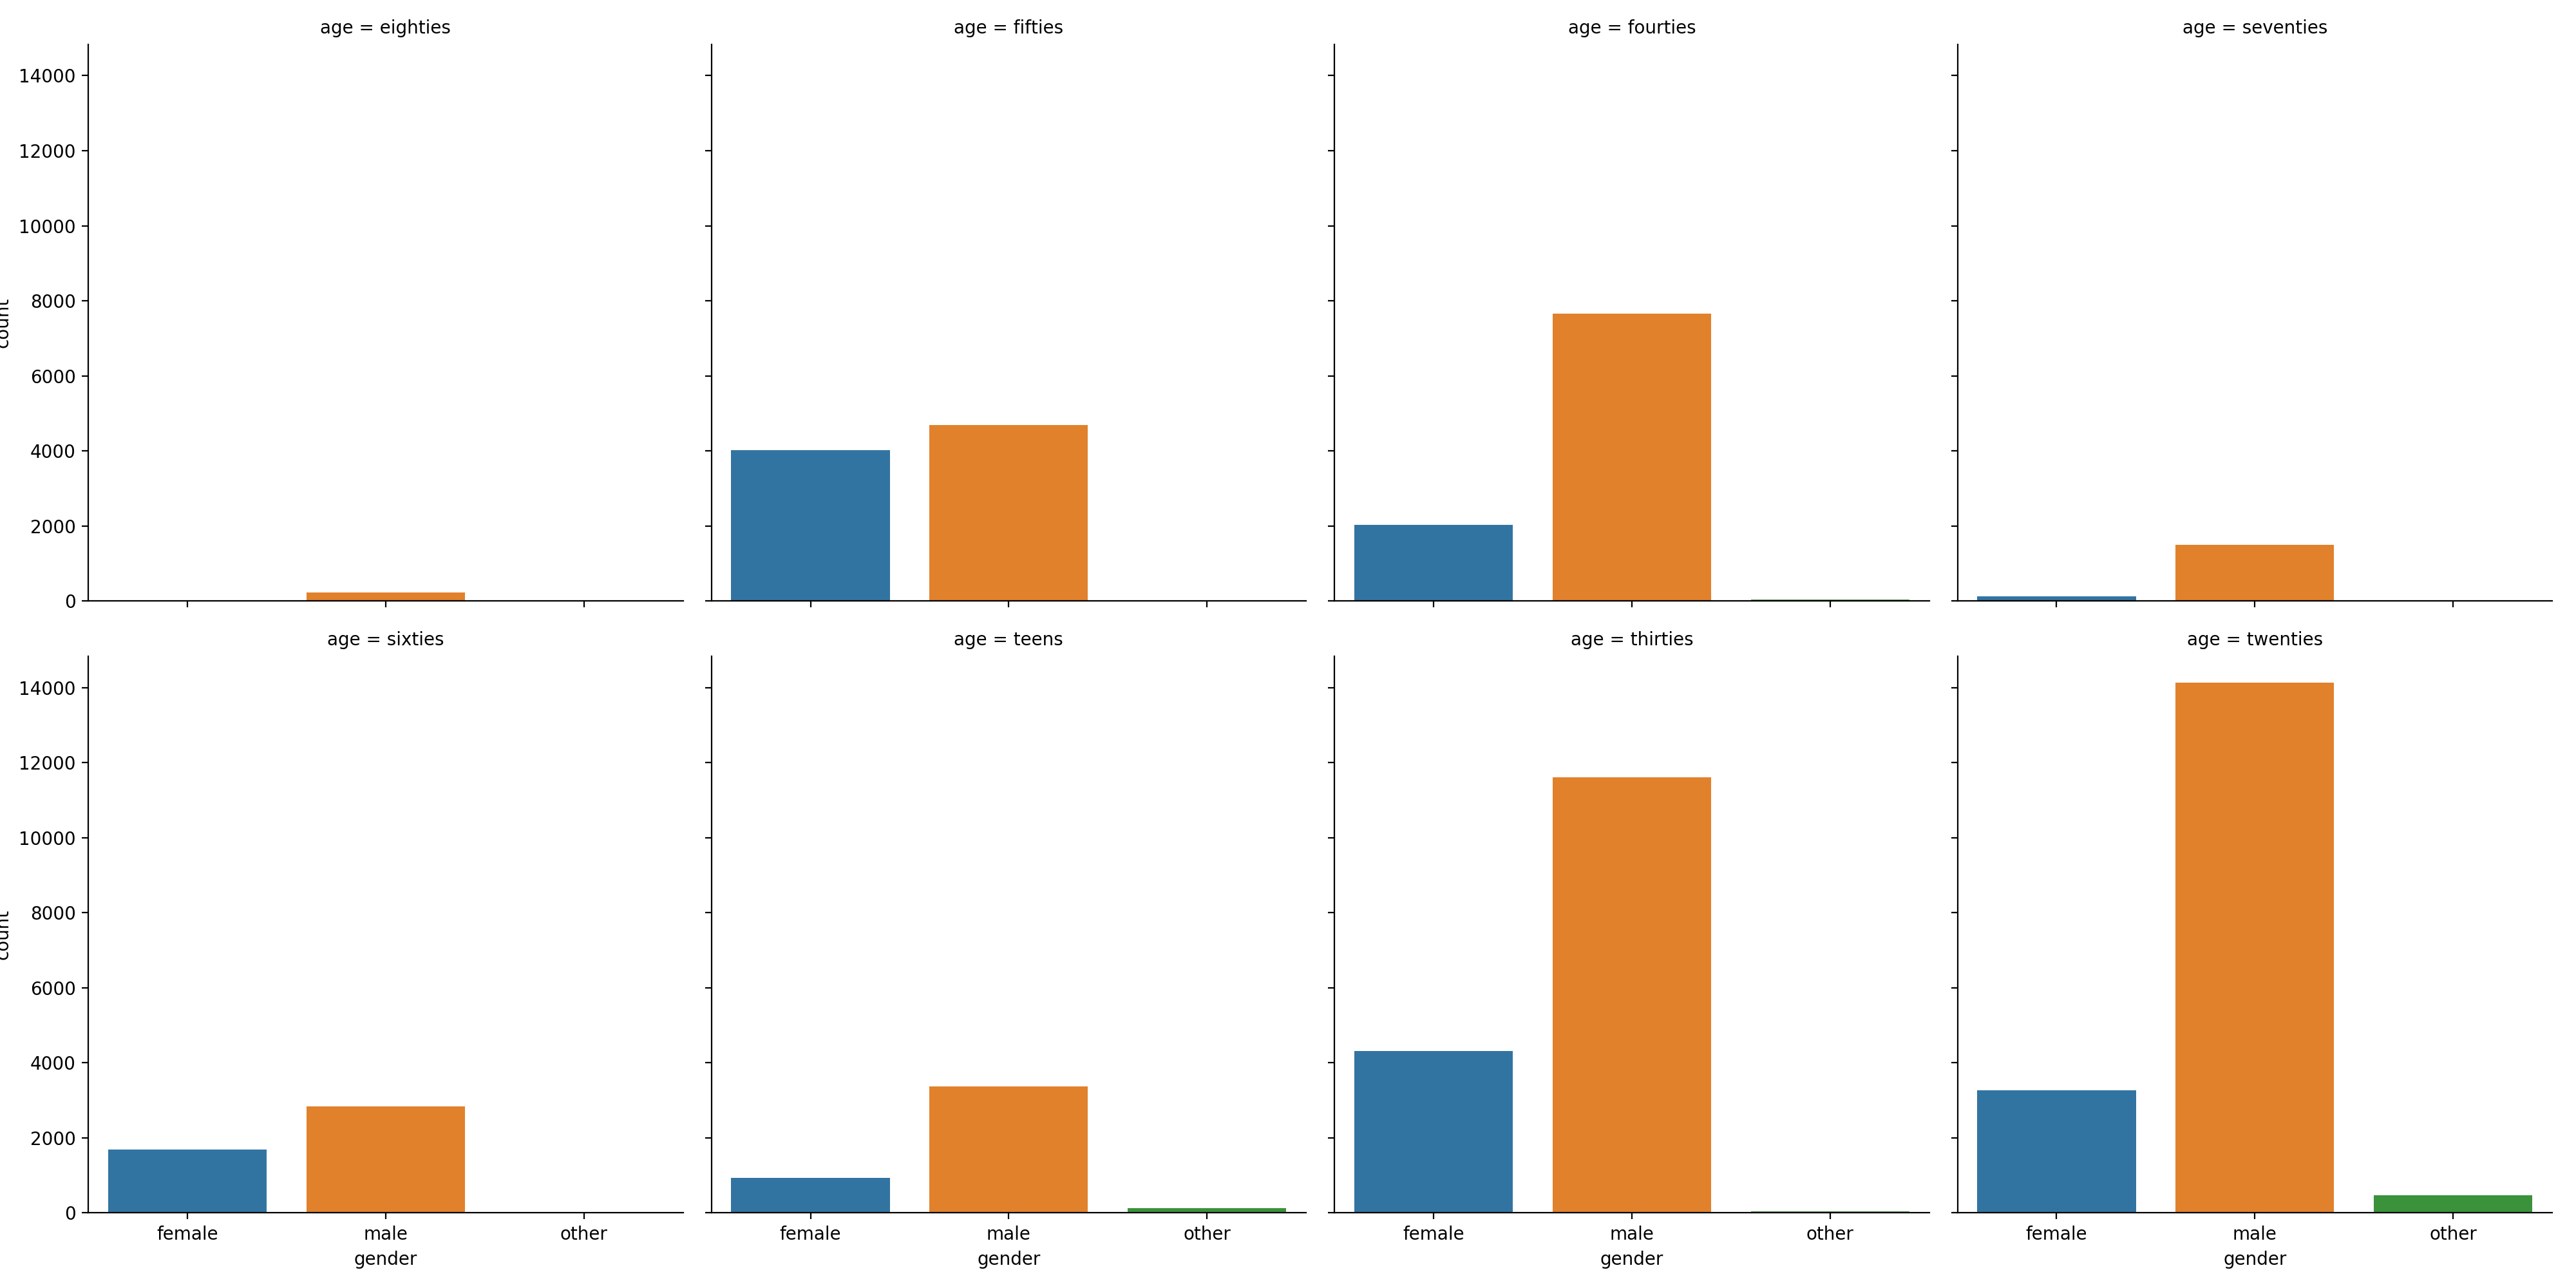

In [23]:
sns.catplot(data=data, x='gender', kind='count', col='age', col_wrap=4)

In [25]:
y, r = librosa.load('./data/cv_corpus_v1/cv-valid-train/sample-043528.mp3')

In [26]:
y = np.array(y)
y

array([ 2.1920941e-07, -2.4629907e-07,  2.6953737e-07, ...,
        1.1421641e-06, -3.2672499e-08,  0.0000000e+00], dtype=float32)

<IPython.core.display.Javascript object>


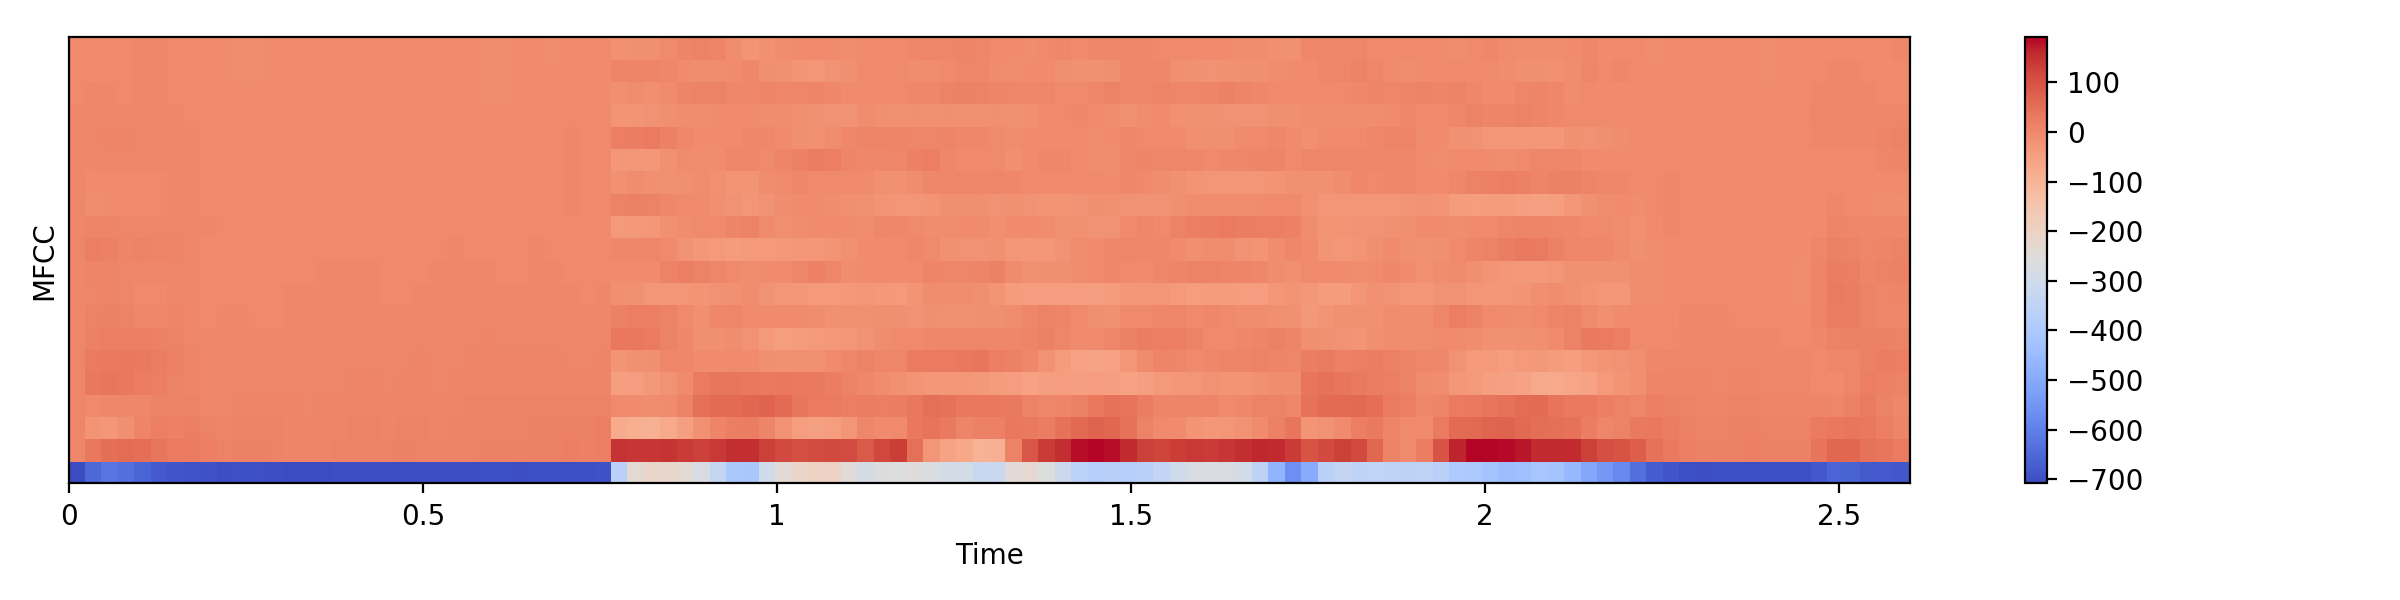

In [27]:
mfcc = librosa.feature.mfcc(y, sr=r)

mfcc.shape

plt.figure(figsize=(12, 3))

plt.subplot(1,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
plt.tight_layout()

In [28]:
y.shape

(57154,)

In [29]:
mfcc.shape

(20, 112)

In [52]:
def filename_to_path(filename, suffix=''):
    return './data/cv_corpus_v1/' + filename + suffix

In [32]:
def batch(iterable, n=1):
        l = len(iterable)
        for ndx in range(0, l, n):
            yield iterable[ndx:min(ndx + n, l)]

In [33]:
def compile_mfcc(filename, max_mfcc_length = 1000):
    y, r = librosa.load(filename_to_path(filename))
    mfcc = librosa.feature.mfcc(y, sr=r)
    original_length = mfcc.shape[1]
    
    hkl_filename = filename_to_path(filename, '.hkl')
    
    if original_length <= max_mfcc_length:
        padded = np.pad(mfcc, ((0,0), (0, max_mfcc_length - original_length)), 'constant')
        
        hkl.dump((mfcc, original_length), hkl_filename, mode='w')
        
    return hkl_filename

In [34]:
def precompile_mfccs(data, max_mfcc_length = 1000, num_processes = 1):
    """
    For each mp3 file in the data frame, compiles the mfcc
    and stores it in a file for quick access during the training
    """
    
    pool = multiprocessing.Pool(num_processes)
    
    progress = FloatProgress(min=0, max=data.shape[0])
    display(progress)
    
    for filenames in batch(data.filename.tolist(), num_processes):
        hkls = zip(*pool.map(compile_mfcc, filenames))
        
        for _ in hkls:
            progress.value += 1

In [ ]:
print "Precompiling training data:"
precompile_mfccs(data, num_processes = 8)

Precompiling training data:


FloatProgress(value=0.0, max=63163.0)

In [ ]:
print "Precompiling test data:"
precompile_mfccs(test_data, num_processes = 8)

In [ ]:
print "Precompiling eval data:"
precompile_mfccs(eval_data, num_processes = 8)

Let's now filter the data, train_data and eval_data, weeding out the rows that didn't get their precompiled hickle dump:

In [53]:
def has_hickle_dump(row):
    filename = row.filename
    hickle_dump_name = filename_to_path(filename, '.hkl')
    
    return os.path.isfile(hickle_dump_name) and os.access(hickle_dump_name, os.R_OK)

In [55]:
data = data[data.apply(has_hickle_dump, axis=1)]

In [70]:
test_data = test_data[test_data.apply(has_hickle_dump, axis=1)]

In [72]:
eval_data = eval_data[eval_data.apply(has_hickle_dump, axis=1)]

In [78]:
data.sample(n=5).apply(lambda row: filename_to_path(row.filename, '.hkl'), axis=1).tolist()

['./data/cv_corpus_v1/cv-valid-train/sample-026344.mp3.hkl',
 './data/cv_corpus_v1/cv-valid-train/sample-052208.mp3.hkl',
 './data/cv_corpus_v1/cv-valid-train/sample-026170.mp3.hkl',
 './data/cv_corpus_v1/cv-valid-train/sample-009658.mp3.hkl',
 './data/cv_corpus_v1/cv-valid-train/sample-087052.mp3.hkl']

In [ ]:
class Codec:
    def __init__(self, data_frames):
        pass
    
    def encode(self, text):
        pass
    
    def decode(self, codes):
        pass

In [55]:
class DataProvider:
    def __init__(self, data_frame, batch_size, codec):
        self.data_frame = data_frame
        self.batch_size = batch_size
        self.codec = codec
        self.current_batch_ix = 0
        
    @property
    def items_served(self):
        return self.current_batch_ix * self.batch_size
    
    @property
    def items_total(self):
        return self.data_frame.shape[0]
        
    def rewind(self):
        self.current_batch_ix = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def get_row_data(self, row):
        """
        Returns the triplet for a row consiting of:
        * MFCC
        * Coded Text
        * Length of the original MFCC before the padding
        """
        pass
    
    def next(self):
        if self.items_served > self.items_total:
            self.rewind()
            
            raise StopIteration()
        else:
            self.current_batch_ix += 1
            
            batch_sample = self.data_frame.sample(n=self.batch_size)
            triplets = batch_sample.apply(self.get_row_data, axis=1).tolist()

            mfccs = [ triplet[0] for triplet in triplets ]
            codes = [ triplet[1] for triplet in triplets ]
            lengs = [ triplet[2] for triplet in triplets ]
            
            return np.stack(mfccs), np.stack(codes), np.stack(lengs)

In [41]:
class SpeechNet(tf.keras.Model):
    def __init__(self):
        super(SpeechNet, self).__init__()
        pass
    
    def call(self, input):
        pass

In [62]:
def testit():
    ix = 1
    provider = DataProvider(data_frame=data, batch_size=8)
    
    for mfccs, texts in provider:
        print "MFCCS shape: " + str(mfccs.shape)
        print "Texts: " + str(texts) + "\n\n---\n"
        if ix >= 3:
            break
        else:
            ix += 1
testit()

MFCCS shape: (8, 13, 252)
Texts: ["he was already re accustomed to desert's silence", 'and that other honeymoon in a coal mine', 'if what one finds is made of pure matter it will never spoil', 'we lit the lantern and walked over to his house', 'was the doctor here', 'he had seen the shooting star and was persuaded that a meteorite lay somewhere nearby', 'the boy was surprised at his thoughts', "i'm going to them"]

---

MFCCS shape: (8, 13, 252)
Texts: ['the top had certainly ceased to rotate', 'be sure you soap his head thoroughly', "you've got the mayor and pullman backed against a wall", 'when he saw henderson in his garden he called over the fence and made himself understood', 'when he saw henderson in his garden he called over the fence and made himself understood', "don't sit there like a frozen robin", 'you two fellas sit in here', 'of course it is']

---

MFCCS shape: (8, 13, 252)
Texts: ['i want to stay at the oasis the boy answered', 'a boy came running towards me', 'remember

In [66]:
def testit():
    ix = 1
    provider = DataProvider(data_frame=data, batch_size=8)
    
    for _, _ in provider:
        if ix % 10 == 0:
            clear_output()
            print str(ix)
        ix += 1
    print "Number of iterations in a batch: " + str(ix)
testit()

7890
Number of iterations in a batch: 7897


In [69]:
data.shape[0] / 8.0

7895.375